#0. Download dataset

In [1]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.7 MB/s eta 0:00:00


In [2]:
!pip install gdown

In [3]:
import gdown

file_id_1 = "1z-5X2cGDNomtfUyJ0LUD10_t0mmJ4rSN"
file_id_2 = "1nMm-eCb72hojZaxuRzfxxF2YPUOW1zLg"

output_file_1 = "feature.csv"
output_file_2 = "label.csv"

gdown.download(f"https://drive.google.com/uc?id={file_id_1}", output_file_1)
gdown.download(f"https://drive.google.com/uc?id={file_id_2}", output_file_2)

Downloading...
From: https://drive.google.com/uc?id=1z-5X2cGDNomtfUyJ0LUD10_t0mmJ4rSN
To: /content/feature.csv
100%|██████████| 4.62M/4.62M [00:00<00:00, 30.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1nMm-eCb72hojZaxuRzfxxF2YPUOW1zLg
To: /content/label.csv
100%|██████████| 256k/256k [00:00<00:00, 7.02MB/s]


'label.csv'

# 1. Description of the problem






The problem we aim to address using data science techniques is the prediction of individuals' likelihood to receive their H1N1 (h1n1_vaccine) and seasonal flu vaccines (seasonal_vaccine).

This problem has a significant importance for several reasons:
- Improving vaccination rates can have a substantial impact on public health. Higher vaccine coverage reduces the spread of infectious diseases like the flu, ultimately saving lives and reducing the burden on healthcare systems.
- A predictive model can lead to cost savings by optimizing the distribution of vaccines and resources, minimizing waste, and reducing the economic burden of treating preventable diseases.
- Healthcare providers can reach out to individuals at risk of not getting vaccinated, addressing concerns or providing information to increase vaccination rates.

The machine learning model can contribute to addressing this problem in several ways:

- The model can assist in allocating vaccination resources more efficiently, ensuring that vaccines are distributed where they are needed the most.

- Early predictions can provide a warning system for potential vaccination gaps, allowing for timely responses and proactive interventions.

- The insights from the model can inform policy decisions, helping authorities design more effective public health campaigns.

# 2. Description of the data


In [4]:
# Importing necessary modules
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
RANDOM_SEED = 42
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

## 2.1. Loading data

In [5]:
# Loading dataset
df_feats = pd.read_csv('feature.csv', index_col="respondent_id")
df_labels = pd.read_csv('label.csv', index_col="respondent_id")

In [6]:
print ("Number of observations in the feature dataset: ", df_feats.shape[0])
print ("Number of features: ", df_feats.shape[1])
print ("Number of observations in the label dataset: ", df_labels.shape[0])
print ("Number of target variables: ", df_labels.shape[1])

Number of observations in the feature dataset:  26707
Number of features:  35
Number of observations in the label dataset:  26707
Number of target variables:  2


In [7]:
# Check if the rows match up between the features and the labels
def check():
  np.testing.assert_array_equal(df_feats.index.values, df_labels.index.values)
  print('The rows between the features and the labels match up')
check()

The rows between the features and the labels match up


In [8]:
# Merging data
df = df_feats.join(df_labels)
df.shape

(26707, 37)

In [9]:
df.corrwith(df['seasonal_vaccine']).sort_values(ascending=False)

seasonal_vaccine               1.000000
opinion_seas_risk              0.390106
h1n1_vaccine                   0.377143
doctor_recc_seasonal           0.369190
opinion_seas_vacc_effective    0.361875
opinion_h1n1_risk              0.216625
opinion_h1n1_vacc_effective    0.205072
health_insurance               0.200858
doctor_recc_h1n1               0.198607
chronic_med_condition          0.170174
h1n1_concern                   0.154828
health_worker                  0.127311
behavioral_touch_face          0.120228
h1n1_knowledge                 0.120152
behavioral_wash_hands          0.112414
behavioral_avoidance           0.076395
behavioral_large_gatherings    0.064025
behavioral_outside_home        0.053509
behavioral_face_mask           0.050083
opinion_h1n1_sick_from_vacc    0.027404
child_under_6_months           0.012097
behavioral_antiviral_meds      0.006277
opinion_seas_sick_from_vacc   -0.061510
household_adults              -0.064840
household_children            -0.114614


In [10]:
df.corrwith(df['h1n1_vaccine']).sort_values(ascending=False)

h1n1_vaccine                   1.000000
doctor_recc_h1n1               0.393890
seasonal_vaccine               0.377143
opinion_h1n1_risk              0.323265
opinion_h1n1_vacc_effective    0.269347
opinion_seas_risk              0.258571
doctor_recc_seasonal           0.209864
opinion_seas_vacc_effective    0.179272
health_worker                  0.169768
h1n1_concern                   0.121929
health_insurance               0.121170
h1n1_knowledge                 0.117951
chronic_med_condition          0.095207
opinion_h1n1_sick_from_vacc    0.075091
behavioral_wash_hands          0.074712
behavioral_touch_face          0.071648
behavioral_face_mask           0.070498
child_under_6_months           0.066962
behavioral_avoidance           0.047690
behavioral_antiviral_meds      0.040608
behavioral_outside_home        0.021768
behavioral_large_gatherings    0.017822
opinion_seas_sick_from_vacc    0.008360
household_adults               0.007545
household_children            -0.003320


## 2.2. Data visualization

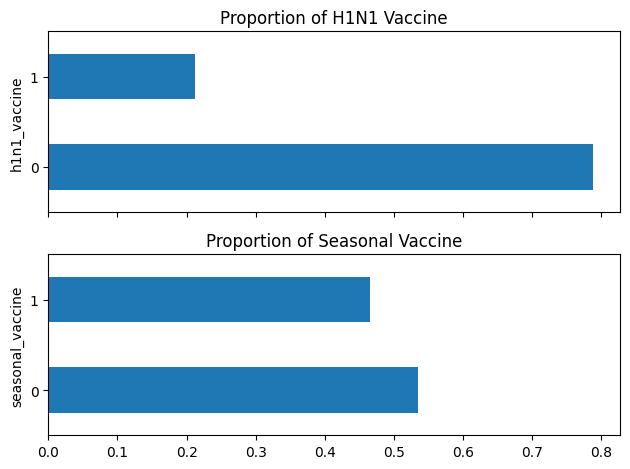

In [11]:
# Distribution of the two target variables
fig, ax = plt.subplots(2, 1, sharex=True)

n_obs = df_labels.shape[0]

(df_labels['h1n1_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of H1N1 Vaccine", ax=ax[0])
)
ax[0].set_ylabel("h1n1_vaccine")

(df_labels['seasonal_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of Seasonal Vaccine", ax=ax[1])
)
ax[1].set_ylabel("seasonal_vaccine")

fig.tight_layout()

- Around half of the population received the seasonal flu vaccine, while only about 20% received the H1N1 flu vaccine.

- In terms of class balance, the **seasonal vaccine** target has roughly equal representation in both classes, making it **balanced**.

- However, the **H1N1 vaccine** target exhibits moderate class **imbalance**.

In [12]:
def vaccination_rate_plot(col, target, data, ax=None):
    counts = (df[[target, col]].groupby([target, col]).size().unstack(target))
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')
    props.plot(kind="barh", stacked=True, ax=ax)
    ax.invert_yaxis()
    ax.legend().remove()

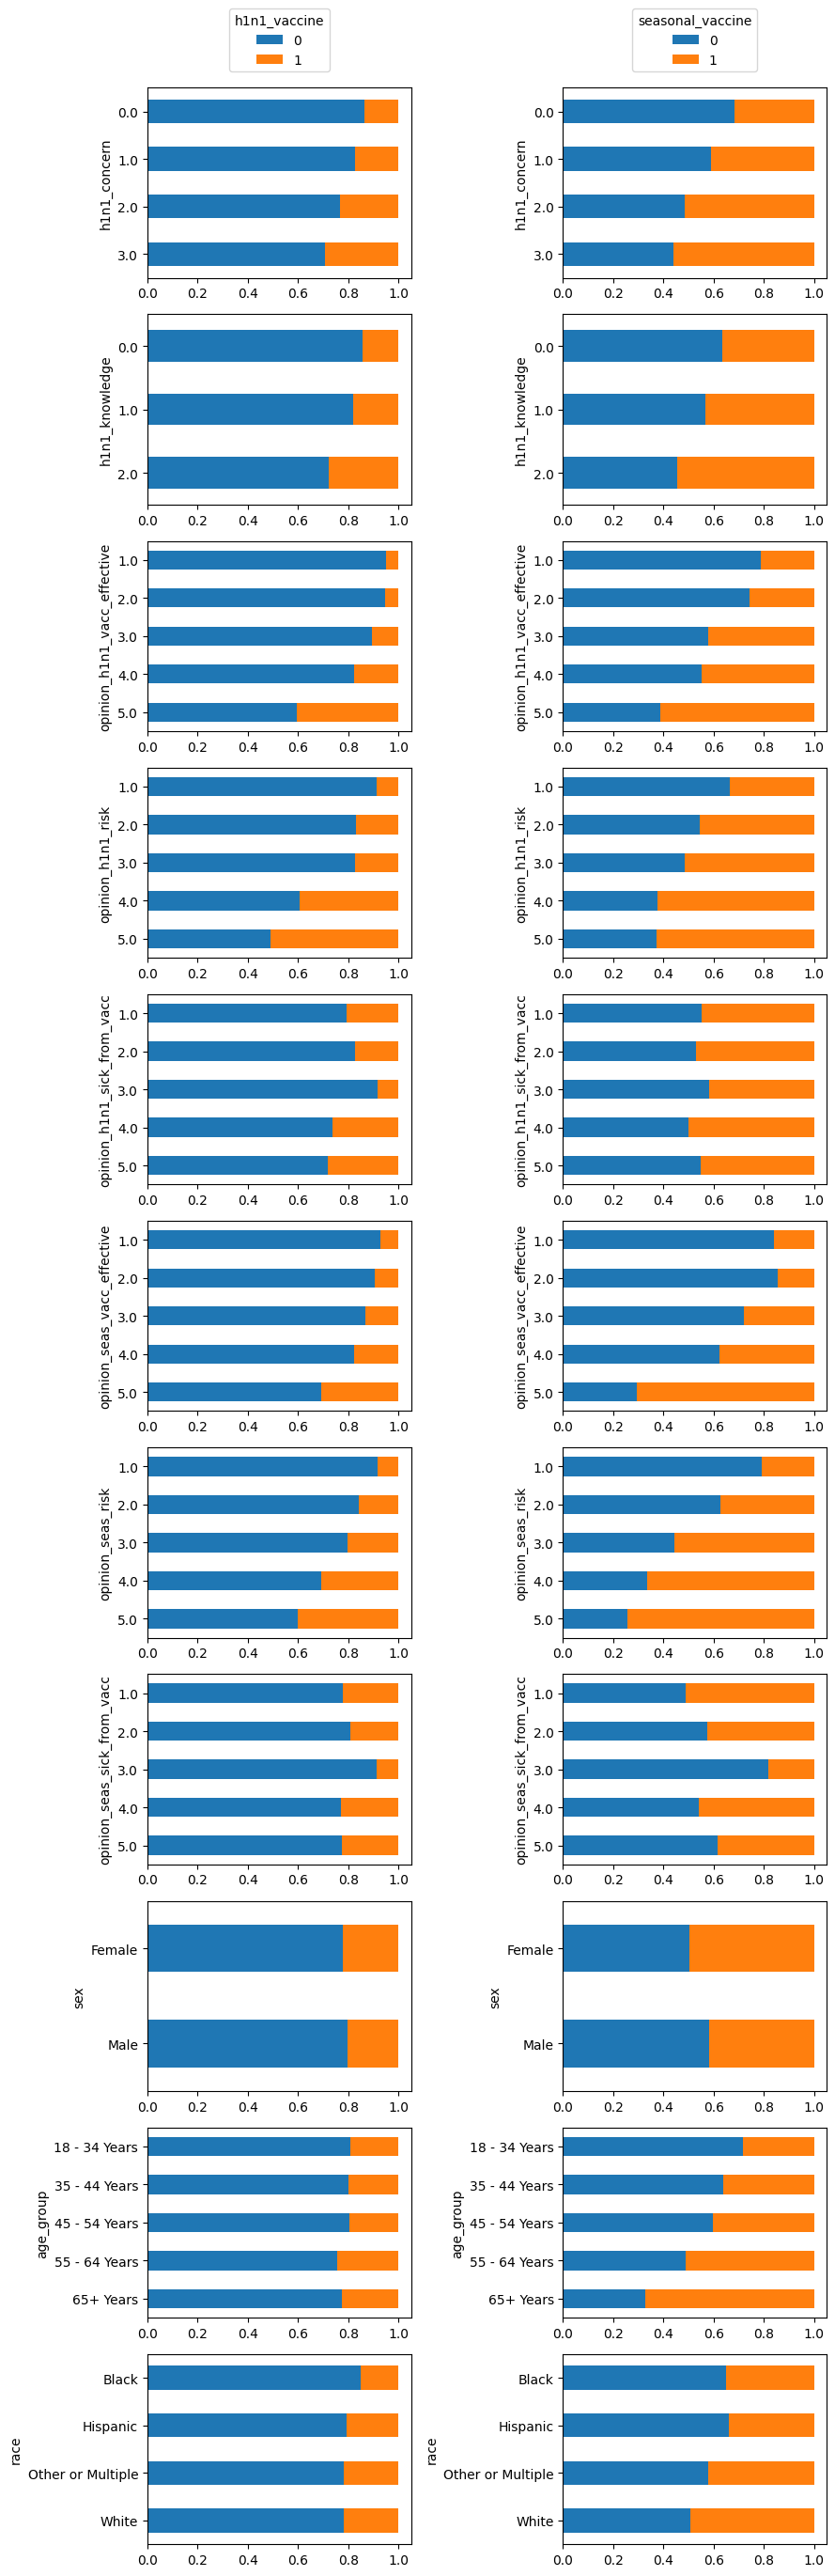

In [13]:
cols_to_plot = [
    'h1n1_concern',
    'h1n1_knowledge',
    'opinion_h1n1_vacc_effective',
    'opinion_h1n1_risk',
    'opinion_h1n1_sick_from_vacc',
    'opinion_seas_vacc_effective',
    'opinion_seas_risk',
    'opinion_seas_sick_from_vacc',
    'sex',
    'age_group',
    'race',
]

fig, ax = plt.subplots(len(cols_to_plot), 2, figsize=(9,len(cols_to_plot)*2.5))
for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(col, 'h1n1_vaccine', df, ax=ax[idx, 0])
    vaccination_rate_plot(col, 'seasonal_vaccine', df, ax=ax[idx, 1])

ax[0, 0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine')
ax[0, 1].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine')
fig.tight_layout()

- It looks like the knowledge and opinion questions have pretty strong signal for both target variables.
- The demographic features have stronger correlation with seasonal_vaccine, but much less so far h1n1_vaccine.
- In particular, we interestingly see a strong correlation with age_group with the seasonal_vaccine but not with h1n1_vaccine.
  + It appears that with seasonal flu, people act appropriately according to the fact that people more impacted and have higher risk of flu-related complications with age.
  + It turns out though that H1N1 flu has an interesting relationship with age: even though older people have higher risk of complications, they were less likely to get infected!

## 2.3. Data exploration

In [14]:
# Check if the two target variables independent?
pd.crosstab(df_labels["h1n1_vaccine"], df_labels["seasonal_vaccine"], margins=True, normalize=True)

seasonal_vaccine,0,1,All
h1n1_vaccine,,,
0,0.497810,0.289737,0.787546
1,0.036582,0.175871,0.212454
All,0.534392,0.465608,1.000000


In [15]:
# Phi Coefficient is the same as Pearson for two binary variables
(df_labels["h1n1_vaccine"].corr(df_labels["seasonal_vaccine"], method="pearson"))

0.37714265306144495

- These two variables have a phi coefficient of 0.37, indicating a moderate ***positive correlation***.

- We can see that in the cross-tabulation as well:
  + A significant proportion of individuals who received the H1N1 flu vaccine also received the seasonal flu vaccine.
  
  + Although a minority of those who received the seasonal vaccine also got the H1N1 vaccine, their rate of H1N1 vaccination is higher than that of individuals who did not receive the seasonal vaccine.

In [16]:
#NaN values
df_feats.isna().sum().sort_values(ascending=False)

employment_occupation          13470
employment_industry            13330
health_insurance               12274
income_poverty                  4423
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
rent_or_own                     2042
employment_status               1463
marital_status                  1408
education                       1407
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
opinion_seas_sick_from_vacc      537
opinion_seas_risk                514
opinion_seas_vacc_effective      462
opinion_h1n1_sick_from_vacc      395
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
household_children               249
household_adults                 249
behavioral_avoidance             208
behavioral_touch_face            128
h1n1_knowledge                   116
h1n1_concern                      92
behavioral_large_gatherings       87
behavioral_outside_home           82
b

# 3.  Data preprocessing



In [17]:
non_numeric_cols = df_feats.columns[df_feats.dtypes == 'object'].values
print(non_numeric_cols)

['age_group' 'education' 'race' 'sex' 'income_poverty' 'marital_status'
 'rent_or_own' 'employment_status' 'hhs_geo_region' 'census_msa'
 'employment_industry' 'employment_occupation']


In [18]:
numeric_cols = df_feats.columns[df_feats.dtypes != "object"].values
print(numeric_cols)

['h1n1_concern' 'h1n1_knowledge' 'behavioral_antiviral_meds'
 'behavioral_avoidance' 'behavioral_face_mask' 'behavioral_wash_hands'
 'behavioral_large_gatherings' 'behavioral_outside_home'
 'behavioral_touch_face' 'doctor_recc_h1n1' 'doctor_recc_seasonal'
 'chronic_med_condition' 'child_under_6_months' 'health_worker'
 'health_insurance' 'opinion_h1n1_vacc_effective' 'opinion_h1n1_risk'
 'opinion_h1n1_sick_from_vacc' 'opinion_seas_vacc_effective'
 'opinion_seas_risk' 'opinion_seas_sick_from_vacc' 'household_adults'
 'household_children']


In [19]:
# Scaling and imputing
non_numeric_preprocessing_steps = Pipeline(steps=[
    ('simple_imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))])
numeric_preprocessing_steps = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('simple_imputer', SimpleImputer(strategy='mean'))
])
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_cols),
        ("non_numeric",non_numeric_preprocessing_steps,non_numeric_cols),
    ],
    remainder = "drop"
)

- To handle missing values in non-numeric features, we will use the SimpleImputer with a strategy of 'constant' to fill missing values with the constant value 'missing'. Then, the categorical features (non-numeric) are one-hot encoded using the OneHotEncoder. The 'handle_unknown' parameter is set to 'ignore' to ensure that any previously unseen categories during testing do not raise errors but are simply ignored. This is essential to maintain consistency between the training and testing datasets.
- To handle missing values in numeric features, we will firstly apply the StandardScaler to bring all numeric features to a common scale, with a mean of 0 and a standard deviation of 1. This prevents features with larger scales from dominating the model's learning process and ensures that each feature contributes equally. After standard scaling, another SimpleImputer is applied to numeric features. This time, the strategy is set to 'mean,' and missing values in numeric features are filled with the mean value of the feature, which is a common approach to dealing with missing data in numerical features.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df_feats,df_labels,test_size=0.33,
                                                    shuffle=True,stratify=df_labels,random_state=RANDOM_SEED)

# 4. Training model


In [21]:
mlp = MLPClassifier()
xgb = XGBClassifier()

estimators_stacked = [('xbg', xgb), ('mlp', mlp)]
stacked_estimator =  StackingClassifier(estimators=estimators_stacked,
                                    final_estimator=LogisticRegression(),
                                    stack_method='predict_proba')

In [22]:
estimators = MultiOutputClassifier(estimator=stacked_estimator)
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("estimators", estimators),
])

In [23]:
# Train model
full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('simple_imputer',
                                                                   SimpleImputer())]),
                                                  array(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask',
       'behavioral_wash_hands', 'behavioral_large_gatherings',
       'behavioral_outsid...
                                                                                               max_bin=None,
                                                                                               max_cat_threshold=None,
                                                                                               max_cat_to_onehot=None,
                                                                                               max_delta_step=None,
                                                                                               max_depth=None,
                                                                                               max_leaves=None,
                                                                                               min_child_weight=None,
                                                                                               missing=nan,
                                                                                               monotone_constraints=None,
                                                                                               multi_strategy=None,
                                                                                               n_estimators=None,
                                                                                               n_jobs=None,
                                                                                               num_parallel_tree=None,
                                                                                               random_state=None, ...)),
                                                                                ('mlp',
                                                                                 MLPClassifier())],
                                                                    final_estimator=LogisticRegression(),
                                                                    stack_method='predict_proba')))])

In [24]:
# Predict on evaluation set
preds = full_pipeline.predict_proba(X_test)
preds

[array([[0.92939234, 0.07060766],
        [0.12569391, 0.87430609],
        [0.93206825, 0.06793175],
        ...,
        [0.1171458 , 0.8828542 ],
        [0.92880156, 0.07119844],
        [0.26427281, 0.73572719]]),
 array([[0.86753348, 0.13246652],
        [0.10747407, 0.89252593],
        [0.85716227, 0.14283773],
        ...,
        [0.1238727 , 0.8761273 ],
        [0.53967479, 0.46032521],
        [0.36167864, 0.63832136]])]

In [25]:
y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": preds[0][:, 1],
        "seasonal_vaccine": preds[1][:, 1],
    },
    index = y_test.index
)
print("y_preds.shape:", y_preds.shape)
y_preds.head()

y_preds.shape: (8814, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
6368,0.070608,0.132467
12566,0.874306,0.892526
13996,0.067932,0.142838
12769,0.874393,0.902931
16915,0.069938,0.169424


In [26]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

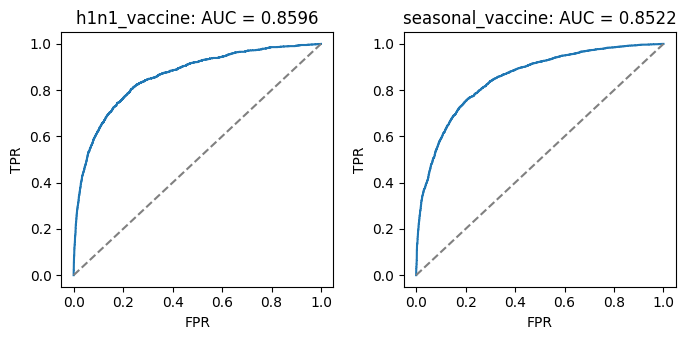

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    y_test['h1n1_vaccine'],
    y_preds['h1n1_vaccine'],
    'h1n1_vaccine',
    ax=ax[0]
)
plot_roc(
    y_test['seasonal_vaccine'],
    y_preds['seasonal_vaccine'],
    'seasonal_vaccine',
    ax=ax[1]
)
fig.tight_layout()

In [28]:
roc_auc_score(y_test, y_preds)

0.8558697013515308

Our roc_auc_score is around 0.856. We can fine-tune the model to improve it.

# 5. Fine-tuning model

In [29]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [30]:
# Define the objective function for MLPClassifier hyperparameter tuning
def objective_mlp(trial):
    activation = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
    learning_rate = trial.suggest_categorical("learning_rate", ["constant", "invscaling", "adaptive"])
    learning_rate_init = trial.suggest_uniform("learning_rate_init", 0.001, 0.1)
    alpha = trial.suggest_loguniform('alpha', 1e-6, 1e-2)
    max_iter = trial.suggest_int("max_iter", 100, 1000)

    mlp = MLPClassifier(
        activation=activation,
        learning_rate=learning_rate,
        learning_rate_init=learning_rate_init,
        max_iter=max_iter,
        alpha=alpha,
        shuffle=True,
        random_state=RANDOM_SEED
    )

    mlp.fit(X_train, y_train)
    y_prob = mlp.predict_proba(X_test)

    return 1.0 - roc_auc_score(y_test, y_prob)

# Define the objective function for XGBClassifier hyperparameter tuning
def objective_xgb(trial):
    learning_rate = trial.suggest_uniform("learning_rate", 0.01, 0.3)
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 5)
    gamma = trial.suggest_uniform("gamma", 0, 1)
    subsample = trial.suggest_uniform("subsample", 0.6, 1.0)
    colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.3, 0.9)
    reg_alpha = trial.suggest_uniform("reg_alpha", 0, 1)
    reg_lambda = trial.suggest_uniform("reg_lambda", 1, 20)

    xgb = XGBClassifier(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        objective='binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        random_state=42
    )

    xgb.fit(X_train, y_train)
    y_prob = xgb.predict_proba(X_test)

    return 1.0 - roc_auc_score(y_test, y_prob)

In [31]:
# Initialize Optuna study
study_mlp = optuna.create_study(direction="minimize")
study_xgb = optuna.create_study(direction="minimize")

[I 2023-10-27 09:16:18,550] A new study created in memory with name: no-name-d308fb20-eb87-4508-8b64-f1dd907974e2
[I 2023-10-27 09:16:18,552] A new study created in memory with name: no-name-fe1ee945-5177-45ab-b842-075f038a44fb


In [ ]:
# Optimize MLPClassifier hyperparameters
study_mlp.optimize(objective_mlp, n_trials=100)

[I 2023-10-27 09:16:20,062] Trial 0 finished with value: 0.20516210148772163 and parameters: {'activation': 'identity', 'learning_rate': 'adaptive', 'learning_rate_init': 0.073487295185552, 'alpha': 0.0004717127531186927, 'max_iter': 167}. Best is trial 0 with value: 0.20516210148772163.
[I 2023-10-27 09:17:04,919] Trial 1 finished with value: 0.22847091938432862 and parameters: {'activation': 'tanh', 'learning_rate': 'invscaling', 'learning_rate_init': 0.01151844970235191, 'alpha': 1.7312300366644788e-05, 'max_iter': 689}. Best is trial 0 with value: 0.20516210148772163.
[I 2023-10-27 09:17:19,333] Trial 2 finished with value: 0.23305570508694629 and parameters: {'activation': 'relu', 'learning_rate': 'adaptive', 'learning_rate_init': 0.032988676051549495, 'alpha': 7.508994595159362e-06, 'max_iter': 100}. Best is trial 0 with value: 0.20516210148772163.
[I 2023-10-27 09:17:25,120] Trial 3 finished with value: 0.1739084388198815 and parameters: {'activation': 'relu', 'learning_rate': '

In [ ]:
# Optimize XGBClassifier hyperparameters
study_xgb.optimize(objective_xgb, n_trials=100)

[I 2023-10-27 09:40:44,801] Trial 0 finished with value: 0.13370010524113984 and parameters: {'learning_rate': 0.21508936088299035, 'n_estimators': 458, 'max_depth': 10, 'min_child_weight': 4, 'gamma': 0.9927728239125022, 'subsample': 0.9033085871729445, 'colsample_bytree': 0.4476951399010563, 'reg_alpha': 0.40538578942749415, 'reg_lambda': 17.032408168473868}. Best is trial 0 with value: 0.13370010524113984.
[I 2023-10-27 09:40:49,107] Trial 1 finished with value: 0.1469069682123335 and parameters: {'learning_rate': 0.21166650279373153, 'n_estimators': 312, 'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.8749193955690131, 'subsample': 0.6422427629173507, 'colsample_bytree': 0.6974205281849302, 'reg_alpha': 0.918019537519914, 'reg_lambda': 7.09940475768105}. Best is trial 0 with value: 0.13370010524113984.
[I 2023-10-27 09:40:51,785] Trial 2 finished with value: 0.14382382995162835 and parameters: {'learning_rate': 0.2712065915705112, 'n_estimators': 160, 'max_depth': 7, 'min_child_w

In [ ]:
# Get the best hyperparameters for MLP and XGB
best_params_mlp = study_mlp.best_params
best_params_xgb = study_xgb.best_params

# Create the best estimators using the best hyperparameters
best_est_mlp = MLPClassifier(random_state=RANDOM_SEED, **best_params_mlp)
best_est_xgb = XGBClassifier(random_state=RANDOM_SEED, **best_params_xgb)

# Define the StackingClassifier with the best estimators
estimators_stacked = [('xbg', best_est_xgb), ('mlp', best_est_mlp)]
stacked_estimator = StackingClassifier(estimators=estimators_stacked, final_estimator=LogisticRegression(), stack_method='predict_proba')

In [ ]:
# For MLPClassifier
best_trial_mlp = study_mlp.best_trial

print("Best trial for MLPClassifier:")
print("  Value: {}".format(best_trial_mlp.value))
print("  Params: ")
for key, value in best_trial_mlp.params.items():
    print(f"    {key}={value},")

# For XGBoost
best_trial_xgb = study_xgb.best_trial

print("Best trial for XGBoost:")
print("  Value: {}".format(best_trial_xgb.value))
print("  Params: ")
for key, value in best_trial_xgb.params.items():
    print(f"    {key}={value},")

Best trial for MLPClassifier:
  Value: 0.15357341641293765
  Params: 
    activation=identity,
    learning_rate=constant,
    learning_rate_init=0.003416225406877318,
    alpha=0.0028488521948103565,
    max_iter=801,
Best trial for XGBoost:
  Value: 0.12841536265445985
  Params: 
    learning_rate=0.02272092930756336,
    n_estimators=414,
    max_depth=7,
    min_child_weight=5,
    gamma=0.21063591935384443,
    subsample=0.8717339206205816,
    colsample_bytree=0.6376607631953154,
    reg_alpha=0.6289090657940553,
    reg_lambda=8.070634258534064,


In [ ]:
# Train and evaluate the StackingClassifier
estimators = MultiOutputClassifier(estimator=stacked_estimator)
estimators.fit(X_train, y_train)
y_pred_stacked = estimators.predict_proba(X_test)

In [ ]:
y_preds_ = pd.DataFrame(
    {
        "h1n1_vaccine": y_pred_stacked[0][:, 1],
        "seasonal_vaccine": y_pred_stacked[1][:, 1],
    },
    index = y_test.index
)
print("y_preds.shape:", y_preds_.shape)
y_preds_.head()

y_preds.shape: (8814, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
6368,0.065725,0.099607
12566,0.910050,0.922102
13996,0.066525,0.110932
12769,0.830460,0.926183
16915,0.059213,0.105178


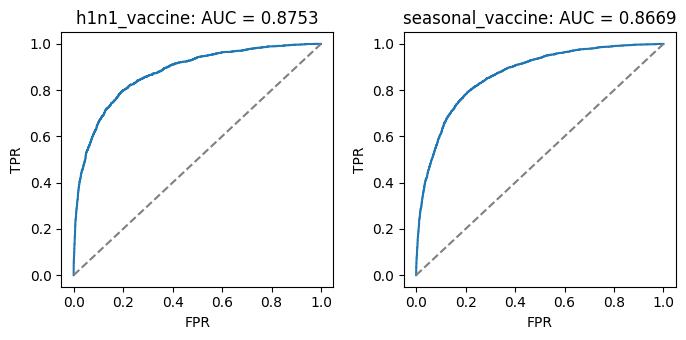

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    y_test['h1n1_vaccine'],
    y_preds_['h1n1_vaccine'],
    'h1n1_vaccine',
    ax=ax[0]
)
plot_roc(
    y_test['seasonal_vaccine'],
    y_preds_['seasonal_vaccine'],
    'seasonal_vaccine',
    ax=ax[1]
)
fig.tight_layout()

In [ ]:
roc_auc_score(y_test, y_preds_)

0.8710993590965987

# 6. Conclusion

The model solves the problem stated at the beginning. It predicts the likelihood of an individual receiving both the H1N1 and seasonal flu vaccines. The model outputs probabilities between 0.0 and 1.0, with higher values indicating a greater likelihood of receiving the vaccine, as shown in the table below. This information can be used to identify individuals who are less likely to get vaccinated and target interventions to increase vaccination rates.

In [ ]:
y_preds_.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
6368,0.065725,0.099607
12566,0.910050,0.922102
13996,0.066525,0.110932
12769,0.830460,0.926183
16915,0.059213,0.105178


- Machine Learning experiments:
  + The machine learning experiments involved data preprocessing, feature engineering, model selection, and hyperparameter tuning.
  + Model interpretability was considered through feature importance analysis, enabling insights into the factors influencing vaccine uptake predictions.
  + The machine learning models, including MLPClassifier and XGBClassifier, have been trained and fine-tuned to predict flu vaccine uptake.
  + ROC AUC score has been evaluated for both models.
  + The models achieved reasonably good performance in predicting flu vaccine uptake, especially for the H1N1 and seasonal flu vaccine.

- Interesting findings:
  + According to the data, older individuals are more likely to be prepared against seasonal flu due to their awareness of being more fragile against it.
  + Also, it turns out that H1N1 has an interesting relationship with age: even though older people have higher risk of complications, they were less likely to get infected! All in all, it seems like the risk factors ended up being reflected in the vaccination rates.

- In real-life scenarios:
  + The model's real-life applicability is rooted in the dataset's representation of responses to a comprehensive questionnaire, reflecting the insights of the general public. This questionnaire encompasses inquiries into individual profiles, spanning aspects such as gender, age group, occupation, education, marital status, and household composition. Additionally, it delves into attitudes, beliefs, perceptions, and experiences related to influenza immunization.
  + This questionnaire holds substantial significance for pharmaceutical and medical institutions, as well as public health and governmental entities. These stakeholders can harness this data to tailor their communication strategies aimed at bolstering influenza vaccine coverage within communities. Leveraging machine learning algorithms with this dataset can markedly enhance the efficiency of public information campaigns.

- The impact of the ML models on the problem domain can be significant:
  + Allocating vaccination resources can be done more efficiently, ensuring that vaccines are distributed where they are needed the most.
  + Early predictions can provide a warning system for potential vaccination gaps, allowing for timely responses and proactive interventions.
  + The insights from the model can inform policy decisions, helping authorities design more effective public health campaigns.

In conclusion, the machine learning model significantly impacts the problem domain of vaccine uptake prediction. It aids in achieving higher vaccination coverage, optimizing resource allocation, and reducing costs. Moreover, it improves public health outcomes by reducing the spread of influenza. The model's adaptable nature and data-driven approach make it a valuable asset for public health planning and decision-making. While it may not solve the problem entirely, it offers a robust and dynamic approach to addressing vaccine uptake challenges.